In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# read in all the words
words = open("words.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [9]:
print(f"# words in project file: {len(words)}")
print(f"min word length: {min(len(w) for w in words)}")
print(f"max word length: {max(len(w) for w in words)}")

# words in project file: 32033
min word length: 2
max word length: 15


In [10]:
# build vocabulary of characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [11]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    
#     print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [12]:
# embedding look-up table 'C'
C = torch.randn((27, 2)) # generate random table size --> (27 characters, 2 columns) 

In [13]:
emb = C[X]
emb.size()

torch.Size([228146, 3, 2])

In [14]:
# hidden layer
# Note 1: We have 3 * 2D embeddings --> 2*3 = 6 rows of weights
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

h = emb.view(-1, 6) @ W1 + b1
# pass h through tanh activation function
h = torch.tanh(h)

W2 = torch.randn(100, 27)
B2 = torch.randn(27)

logits = h @ W2 + B2
logits.shape

torch.Size([228146, 27])

In [15]:
# get our "fake counts"
counts = logits.exp()
# normalize counts into a probability
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [16]:
# calculate loss
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss

tensor(17.8328)

In [17]:
#=====Clean Up=====#
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [18]:
g = torch.Generator().manual_seed(21474833647)
C = torch.randn((27, 2), generator=g) # generate random table size --> (27 characters, 2 columns)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [19]:
sum(p.nelement() for p in parameters)

3481

In [20]:
for p in parameters:
    p.requires_grad = True

In [21]:
# learning rate optimization
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [22]:
lri = []
lossi = []

In [23]:
for i in range(10000):
    
    # minibatch constrcut
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
#     print(loss.item())

    # backward pass
    # set gradients to zero
    for p in parameters:
        p.grad = None

    # populate gradients
    loss.backward()

    # update
    lr = 10e-1
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
#     lri.append(lre[i])
    lossi.append(loss.item())        

In [24]:
loss

tensor(2.1695, grad_fn=<NllLossBackward0>)

In [67]:
# train split, dev/validation split, test, split

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
          #print(''.join(itos[i] for i in context), '--->', itos[ix])
          context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [68]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [81]:
g = torch.Generator().manual_seed(21474833647)
C = torch.randn((27, 10), generator=g) # generate random table size --> (27 characters, 2 columns)
W1 = torch.randn((30, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [82]:
for p in parameters:
    p.requires_grad = True

In [83]:
stepi = []
lossi = []
stepi = []

In [84]:
for i in range(50000):
    
    # minibatch constrcut
    ix = torch.randint(0, Xtr.shape[0], (64,))
    
    # forward
    emb = C[Xtr[ix]] # (32, 3, 2)
    acti = torch.nn.ReLU()
    h = acti(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    # set gradients to zero
    for p in parameters:
        p.grad = None

    # populate gradients
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())   

In [76]:
loss

tensor(2.3823, grad_fn=<NllLossBackward0>)

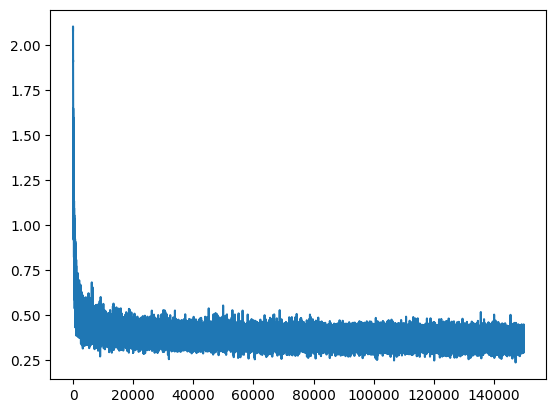

In [77]:
plt.plot(stepi, lossi)

In [78]:
emb = C[Xdev]
h = acti(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3090, grad_fn=<NllLossBackward0>)

In [79]:
emb = C[Xte]
h = acti(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.3150, grad_fn=<NllLossBackward0>)

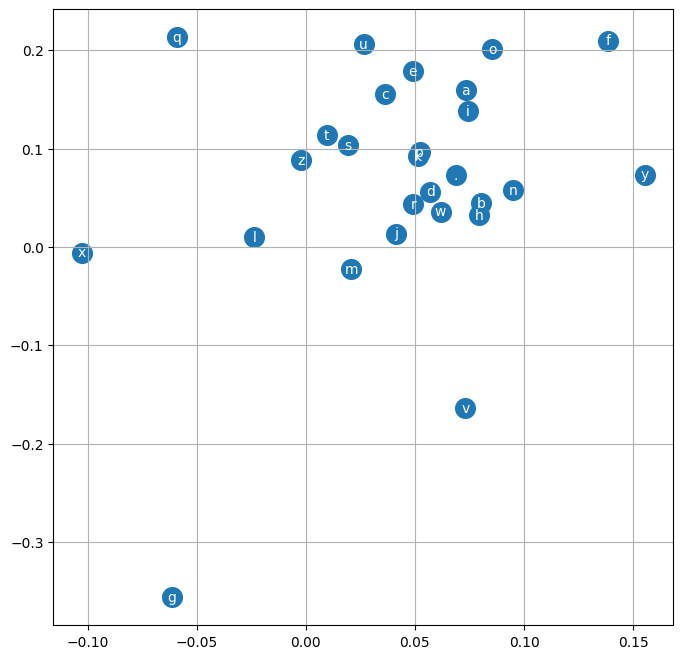

In [80]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [61]:
# sample from neural net model
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = acti(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

cel.
marialius.
rochity.
kell.
imitta.
nylandrika.
da.
samiyah.
javer.
gotti.
